In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [83]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datetime import datetime
# import dateparser
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import pmdarima as pm
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

#reading file, not standart delimeter, providing it(;) to pandas
df1=pd.read_csv('./drive/MyDrive/DeepL/household_power_consumption.txt', delimiter=';', index_col=["Date"], parse_dates=["Date"])

#rewriting to read from excel
#df.to_csv('../temp/timeser.csv',encoding='utf-16', sep='\t', index=False)
df1.dtypes

Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [84]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("R2 score = ", r2_score(y_true, y_pred))
    print("MAE = ", mean_absolute_error(y_true, y_pred))
    print("MedianAE = ", median_absolute_error(y_true, y_pred))
    print("MSE = ", mean_squared_error(y_true, y_pred))
    print("MAPE = ", mean_absolute_percentage_error(y_true, y_pred))

In [92]:
df_real=df1.copy(deep=True)




df_real[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2']]=df_real[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_real['Total_power']=(df_real['Global_active_power']**2+df_real['Global_reactive_power']**2)**0.5



df_real=df_real.drop(columns= ['Sub_metering_1','Sub_metering_2', 'Sub_metering_3'])
df_real.reset_index(inplace=True)
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')


In [93]:
df_real

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Total_power
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,4.236671
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,5.377704
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,5.397025
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,5.411335
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,3.703828
...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.946000
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.944000
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.938000
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.934000


In [94]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Total_power            float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 110.8+ MB


In [95]:
df_real.dropna(inplace=True)

In [96]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Total_power            float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 125.1+ MB


In [97]:
df_real.describe()

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Total_power
count,2049280,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-01 13:00:00.309181952,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.109554e+00
min,2006-12-16 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,7.600000e-02
25%,2007-12-10 00:00:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,3.319036e-01
50%,2008-11-30 00:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,6.340000e-01
75%,2009-11-23 00:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,1.538519e+00
max,2010-11-26 00:00:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,1.112336e+01
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,1.051854e+00


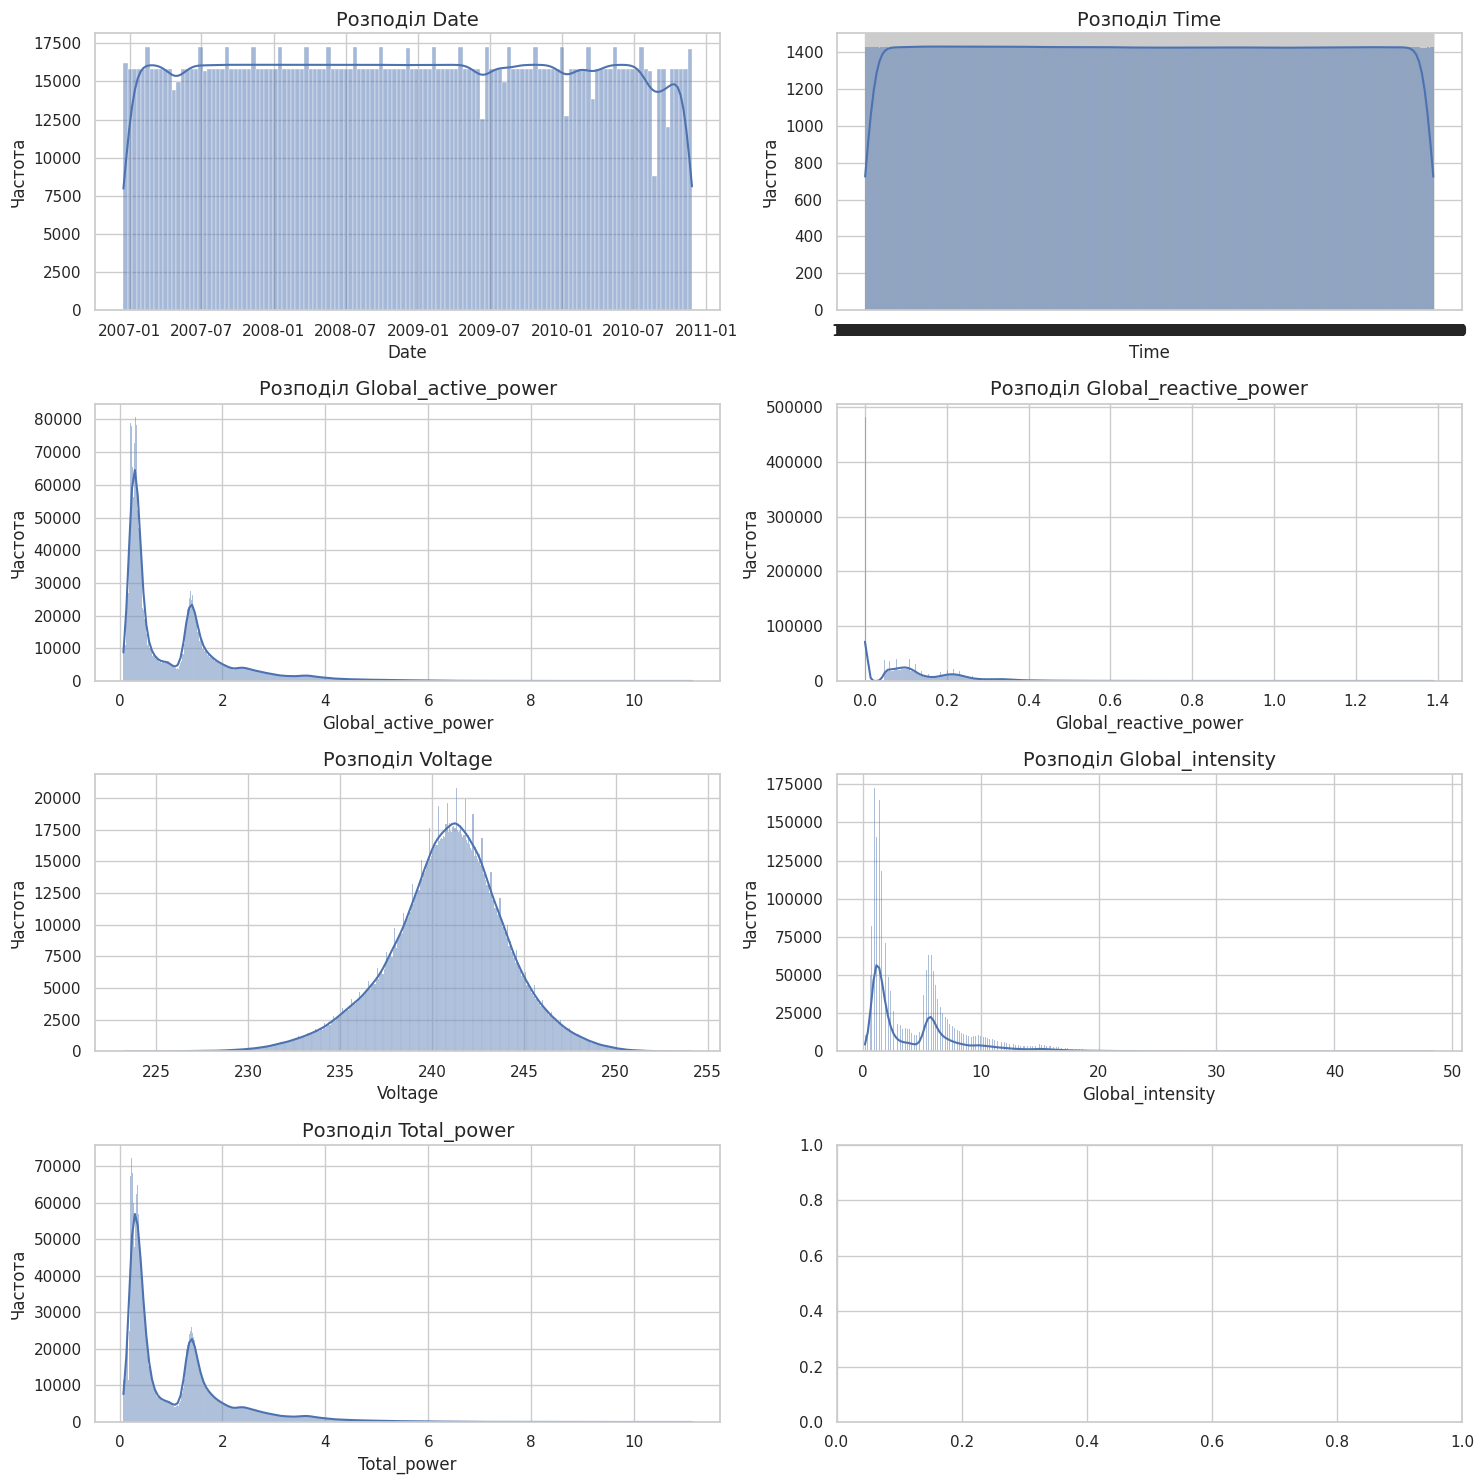

In [98]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(4, 2, figsize=(15, 15))

variables = df_real.columns
for ax, var in zip(axs.flat, variables):
    sns.histplot(df_real[var], kde=True, ax=ax)
    ax.set_title(f'Розподіл {var}', fontsize=14)
    ax.set_xlabel(var)
    ax.set_ylabel('Частота')


plt.tight_layout()
plt.show()

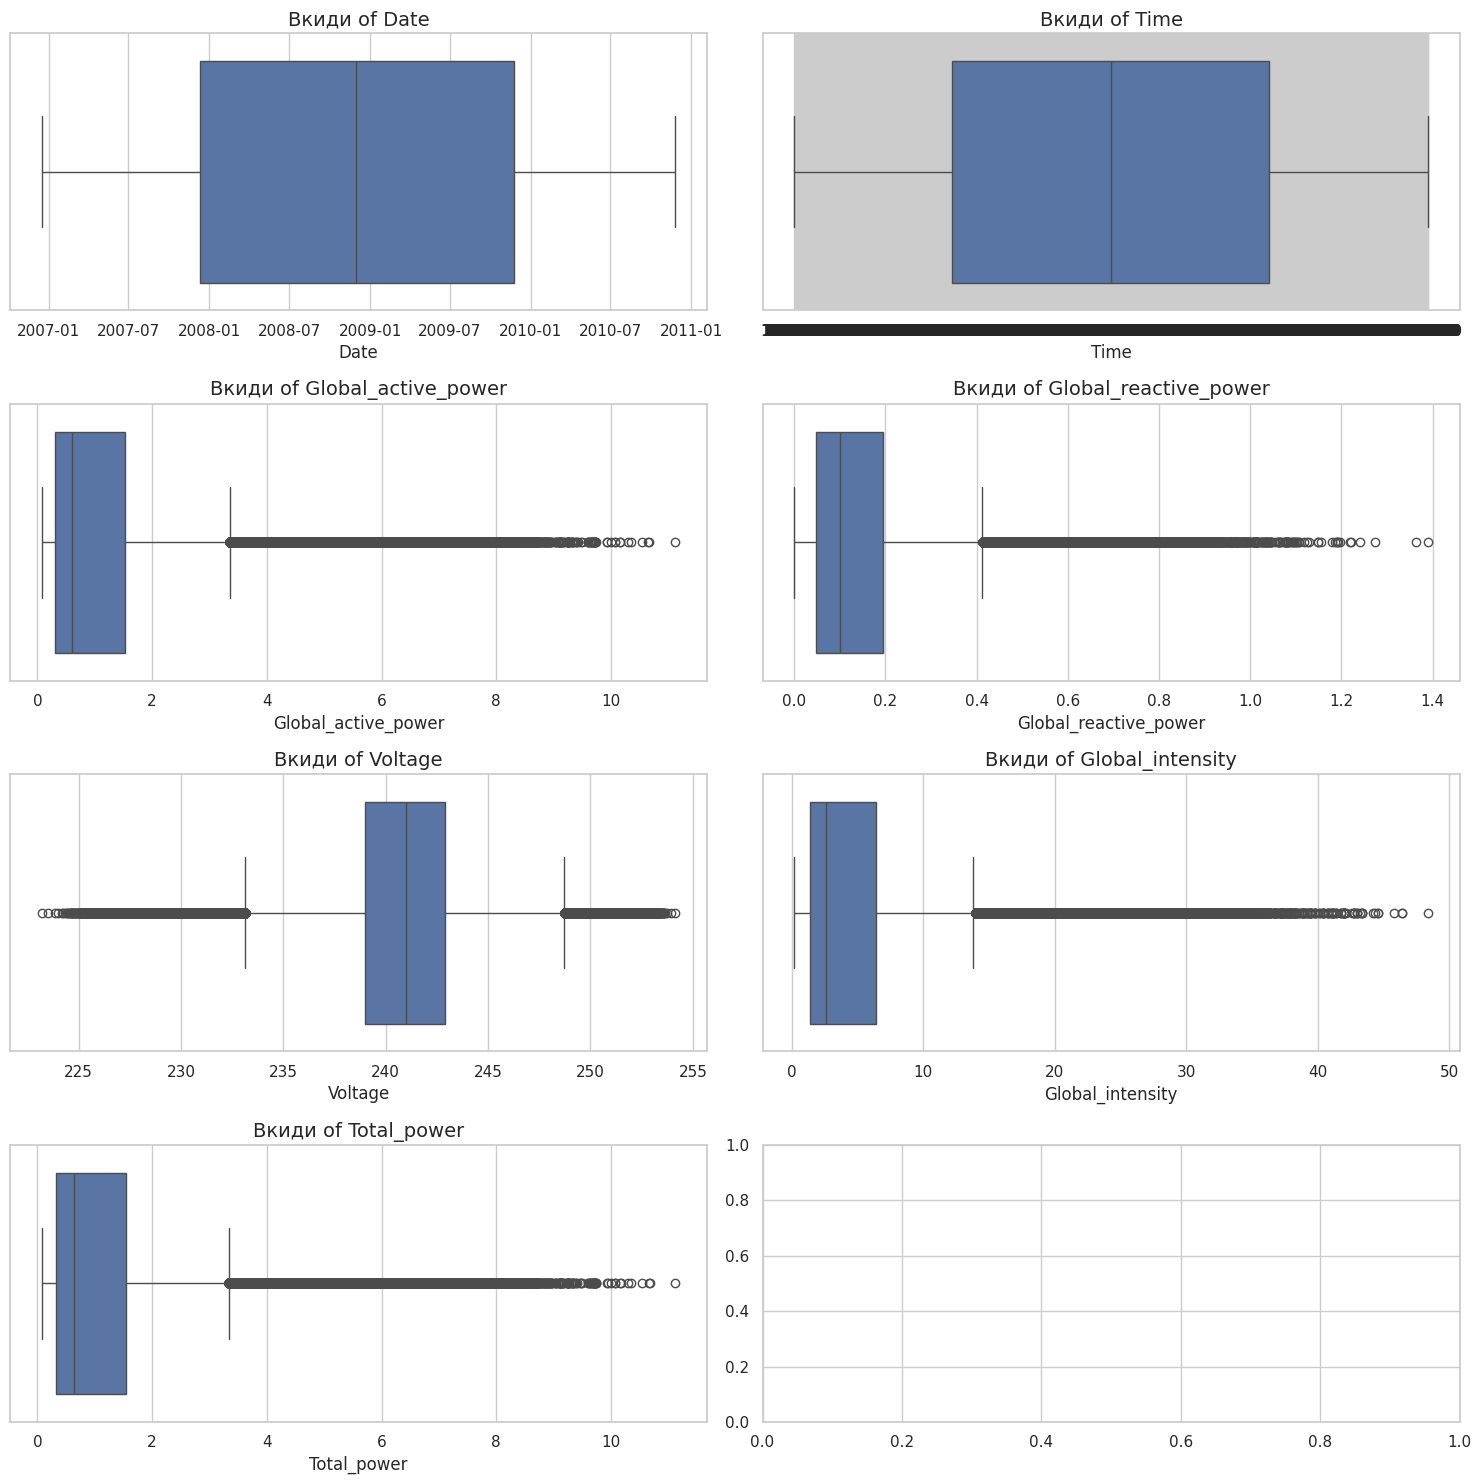

In [99]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for ax, var in zip(axs.flat, variables):
    sns.boxplot(x=df_real[var], ax=ax)
    ax.set_title(f'Викиди of {var}', fontsize=14)


plt.tight_layout()
plt.show()


In [113]:
df_real['datetime'] = pd.to_datetime(df_real['Date'].astype(str) + ' ' + df_real['Time'].astype(str))
df_real['datetime'] = df_real['datetime'].apply(pd.to_datetime, errors='coerce')

In [114]:
df_real['datetime'] = df_real['datetime'].apply(pd.Timestamp.toordinal)
df_real.drop(columns=['Date', 'Time'], inplace=True)


In [115]:
df_real

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Total_power,datetime
0,4.216,0.418,234.84,18.4,4.236671,732661
1,5.360,0.436,233.63,23.0,5.377704,732661
2,5.374,0.498,233.29,23.0,5.397025,732661
3,5.388,0.502,233.74,23.0,5.411335,732661
4,3.666,0.528,235.68,15.8,3.703828,732661
...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.946000,734102
2075255,0.944,0.000,240.00,4.0,0.944000,734102
2075256,0.938,0.000,239.82,3.8,0.938000,734102
2075257,0.934,0.000,239.70,3.8,0.934000,734102


In [116]:
from sklearn.feature_selection import mutual_info_regression


numerical_columns = df_real.columns[:-1]

X = df_real[numerical_columns]
y = df_real['Total_power']

mi_scores = {col: mutual_info_regression(X[[col]], y)[0] for col in numerical_columns}

print(mi_scores)


Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Total_power'],
      dtype='object')
{'Global_active_power': 6.1579159848418445, 'Global_reactive_power': 3.1692812925159792, 'Voltage': 0.16036438922760965, 'Global_intensity': 3.101087174437389, 'Total_power': 10.613950962024534}


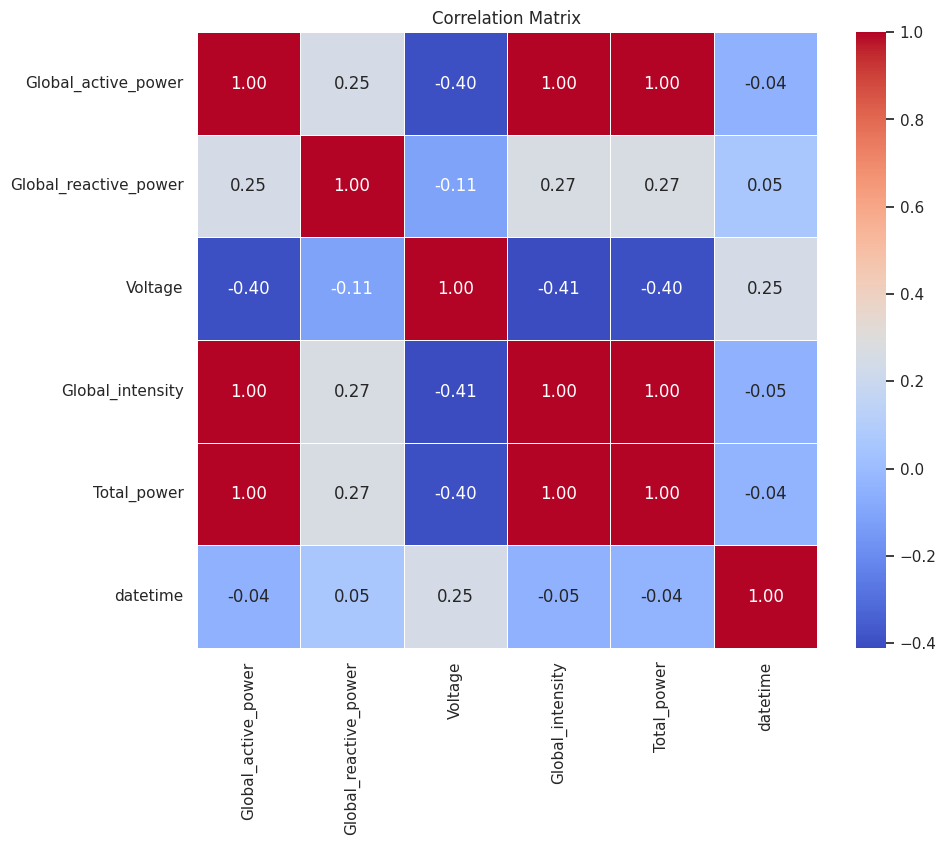

In [117]:
correlation_matrix = df_real.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [15]:
# df_real=df_real.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
# #df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
# df_real


,Total_power
Date,
2006-12-16,4.236671
2006-12-16,5.377704
2006-12-16,5.397025
2006-12-16,5.411335
2006-12-16,3.703828
...,...
2010-11-26,0.946000
2010-11-26,0.944000
2010-11-26,0.938000


In [16]:
df_real=df_real.groupby(by=['Date']).mean()
#df_real.loc['2007-01-01']
df_real.info()
#print(df_real.dropna().count())
#print(df_real.count())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [17]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


In [18]:
df_real['Total_power']=df_real['Total_power'].interpolate(method='time')
df_real.reset_index(inplace=True)
date = pd.DatetimeIndex(df_real['Date'])
df_real.drop(columns='Date', inplace=True)
df_real.set_index(date, inplace=True)
df_real.index.name = 'Date'
df_real=df_real.asfreq('d')

In [19]:
df_real.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Date', length=1442, freq='D')

In [20]:
ADF_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   -3.710666
p-value                           0.003966
Lags Used                        22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


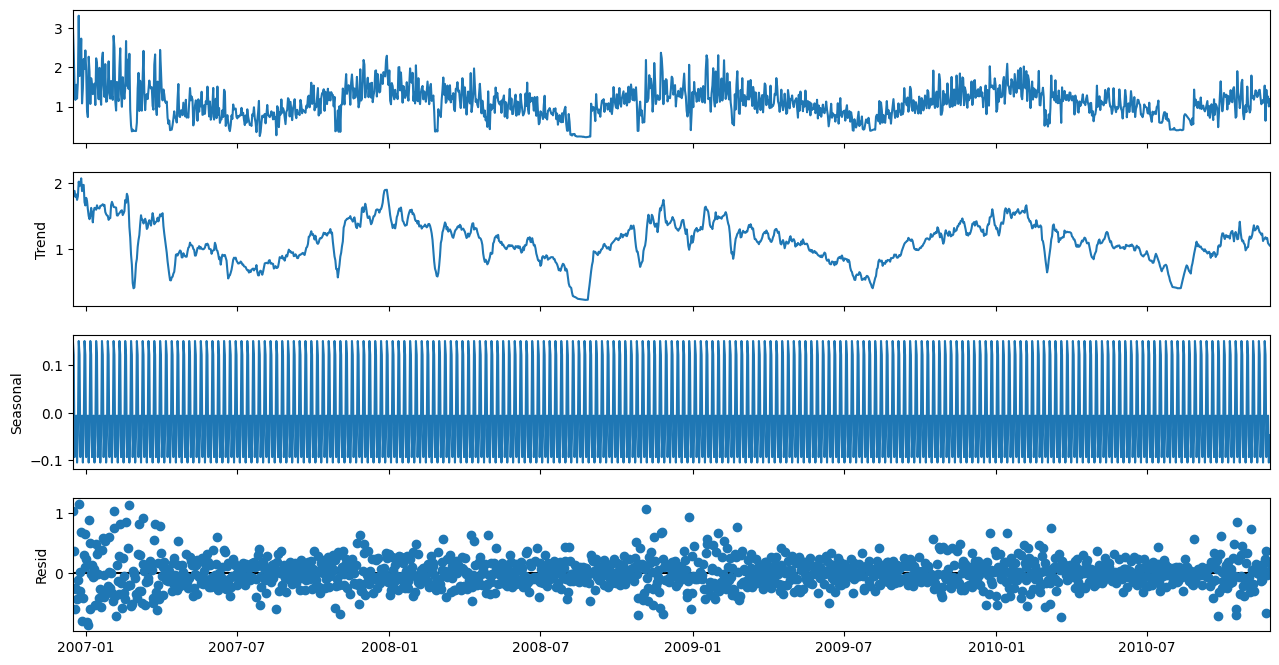

In [21]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()

    return trend, seasonal, residual

trend, seasonal, residual = seasonal_decompose(df_real)

In [22]:
train_data = df_real['Total_power'][:int(len(df_real)*0.8)]
test_data = df_real['Total_power'][int(len(df_real)*0.8):]


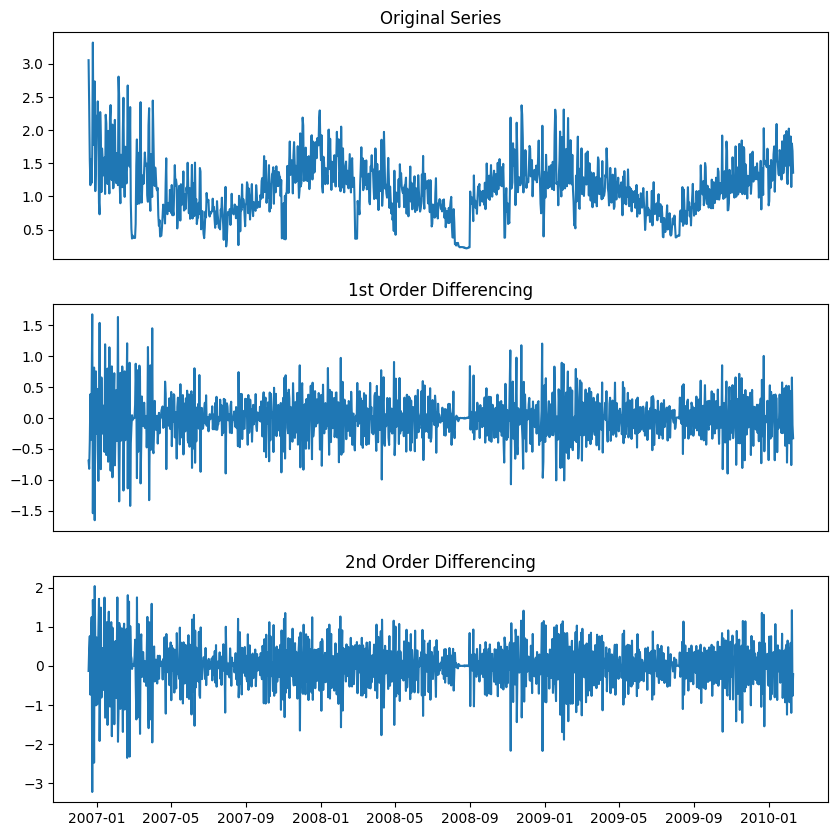

In [23]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

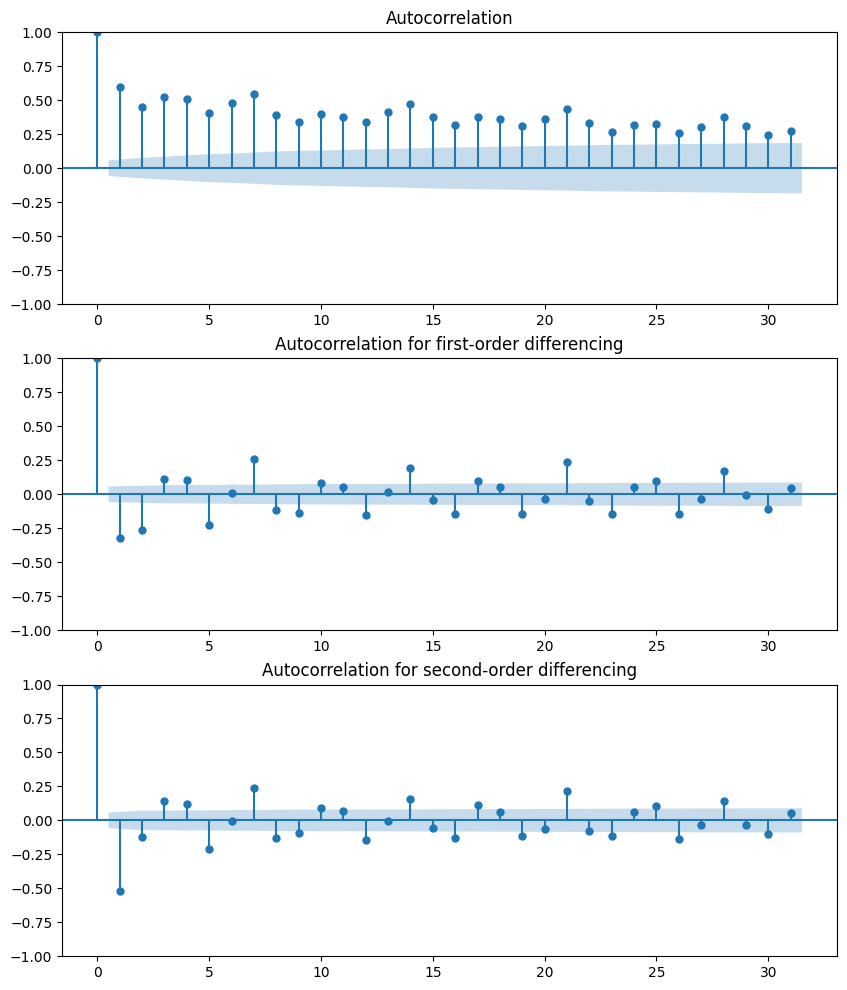

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

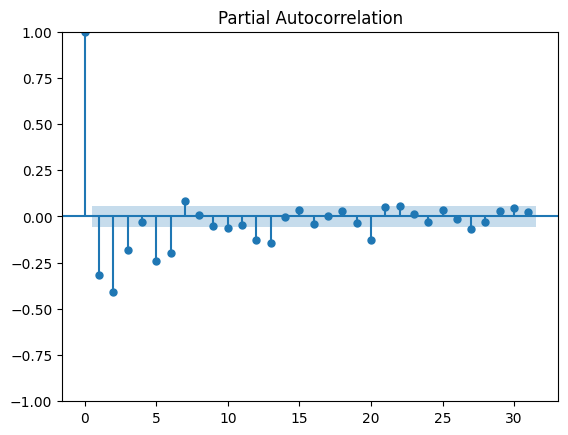

In [25]:
_ = plot_pacf(train_data.diff().dropna())

In [26]:
# Run ADF test to determine order of differencing (d)
result = adfuller(df_real['Total_power'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# If p-value > 0.05, the data are non-stationary and you need to difference the data
if result[1] > 0.05:
    df_real['Total_power'] = df_real['Total_power'].diff().dropna()
    d = 1
else:
    d = 0

ADF Statistic: -3.710666
p-value: 0.003966


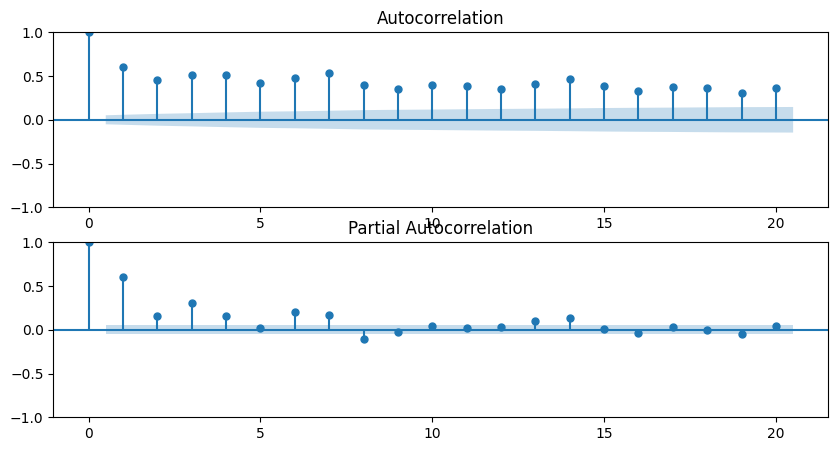

In [28]:
# Plot ACF and PACF charts to find the order of the AR and MA terms
fig, axes = plt.subplots(2, figsize=(10,5))

# Plot the ACF of the differenced series
plot_acf(df_real['Total_power'], lags=20, ax=axes[0])

# Plot the PACF of the differenced series
plot_pacf(df_real['Total_power'], lags=20, ax=axes[1])

plt.show()


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Set p and q based on the plots
# p is where the PACF crosses the upper confidence interval for the first time
# q is where the ACF crosses the upper confidence interval for the first time
p = 4
d = 3
q = 15

# Build the model
model = SARIMAX(df_real['Total_power'], order=(p, d, q))
model_fit = model.fit(disp=False)

# Print out the summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Total_power   No. Observations:                 1442
Model:              SARIMAX(4, 3, 15)   Log Likelihood                -308.502
Date:                Mon, 13 May 2024   AIC                            657.003
Time:                        18:01:35   BIC                            762.437
Sample:                    12-16-2006   HQIC                           696.363
                         - 11-26-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.6434      0.090    -29.353      0.000      -2.820      -2.467
ar.L2         -3.3794      0.161    -21.004      0.000      -3.695      -3.064
ar.L3         -2.5684      0.161    -15.985      0.0

In [30]:
# Forecast
forecast_steps = 10  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

print('Forecast: ')
print(forecast)

Forecast: 
2010-11-27    1.268450
2010-11-28    1.186686
2010-11-29    1.307251
2010-11-30    1.308800
2010-12-01    1.304246
2010-12-02    1.312780
2010-12-03    1.302902
2010-12-04    1.378673
2010-12-05    1.352592
2010-12-06    1.382015
Freq: D, Name: predicted_mean, dtype: float64


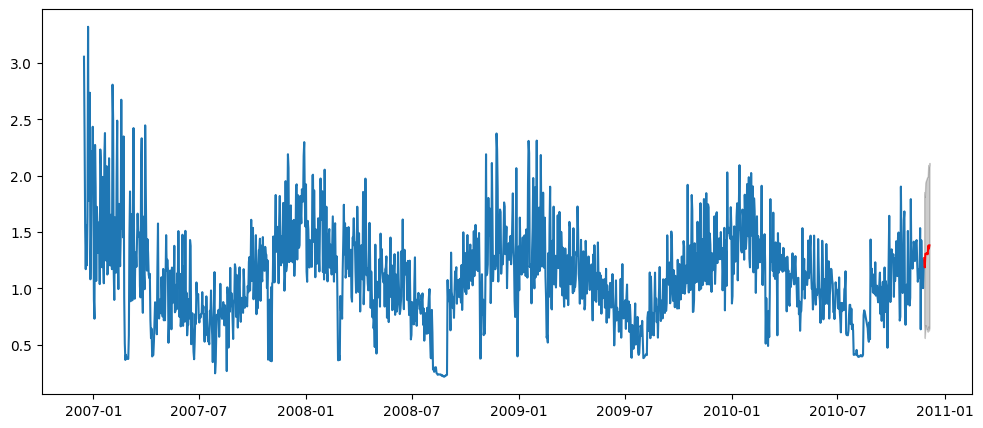

In [31]:
# Get confidence intervals
prediction = model_fit.get_prediction(start=pd.to_datetime('2010-11-27'), end=pd.to_datetime('2010-12-06'), dynamic=False)
prediction_conf = prediction.conf_int()

# Plot the values and their confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(df_real['Total_power'])
plt.plot(prediction.predicted_mean, color='red')
plt.fill_between(prediction_conf.index, prediction_conf.iloc[:, 0], prediction_conf.iloc[:, 1], color='k', alpha=.2)
plt.show()

In [32]:
df_real

,Total_power
Date,
2006-12-16,3.056187
2006-12-17,2.365602
2006-12-18,1.543069
2006-12-19,1.170682
2006-12-20,1.556785
...,...
2010-11-22,1.427137
2010-11-23,1.106567
2010-11-24,1.256433


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
df_real['Date'] = df_real.index.map(pd.Timestamp.toordinal)
X = df_real['Date'].values.reshape(-1, 1)
y = df_real['Total_power'].values

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [62]:
X_test[:10]

array([[ 1.70922947],
       [-0.31349887],
       [ 1.24798975],
       [-0.85641645],
       [-0.69306072],
       [-1.60593099],
       [-1.34888594],
       [ 0.41439506],
       [-0.13092482],
       [-1.34408136]])

In [60]:
x_pred=(prediction_conf['lower Total_power'].values + prediction_conf['upper Total_power'].values)/2

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


model = Sequential([
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=0)


model_evaluation = model.evaluate(X_test, y_test, verbose=0)


predictions = model.predict(X_test)[:10].flatten()

print("Model Loss on Test Data:", model_evaluation)
print("First 5 Predictions:", predictions)


10/10 [==============================] - 0s 2ms/step
Model Loss on Test Data: 0.09411551803350449
First 5 Predictions: [1.0634649  0.6561749  0.9865703  1.3792274  1.3106652  1.3228446
 0.855055   1.0307765  1.1518276  0.84743714]


In [67]:
print('MSE of NN:',mean_squared_error(X_test[:10],predictions ))

MSE of NN: 3.0701855703213092


In [66]:
print('MSE of arima:', mean_squared_error(X_test[:10],x_pred ))

MSE of arima: 3.723885697545326
